In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.offline as po
import plotly.graph_objs as go
from plotly import tools
import load
import descriptions
import gensim
import random
from keras.models import Model
from keras.models import load_model
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Input
import keras
import time
import umap
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from platform import python_version
from slap import *
import warnings
warnings.filterwarnings("ignore")
po.init_notebook_mode(connected=True)
pd.options.mode.chained_assignment = None
pd.set_option('max_colwidth', 100)

Using TensorFlow backend.


In [2]:
keras.__version__

'2.2.4'

In [3]:
print(python_version())

3.7.1


## Patient pathway

In [4]:
%%time

#this was made from the cancerdata_EDA.ipynb
df_full_patient_pathways = pd.read_pickle('full_patient_pathways.pkl')

print("shape of patient_pathways ",df_full_patient_pathways.shape)
display(df_full_patient_pathways.head())

shape of patient_pathways  (777581, 119)


TUMOURID  PATIENTID DIAGNOSISDATEBEST SITE_ICD10_O2 SITE_ICD10_O2_3CHAR  \
15  10001198   10001198        2015-01-16          C443                 C44   
18  10335837   10001198        2015-01-16          C444                 D46   
16  10001198   10001198        2015-01-16          C443                 C44   
17  10001198   10001198        2015-01-16          C443                 C44   
19  10335837   10001198        2015-01-16          C444                 D46   

   MORPH_ICD10_O2 BEHAVIOUR_ICD10_O2 T_BEST N_BEST M_BEST        ...          \
15           8090                  3    NaN    NaN    NaN        ...           
18           8090                  1    NaN    NaN    NaN        ...           
16           8090                  3    NaN    NaN    NaN        ...           
17           8090                  3    NaN    NaN    NaN        ...           
19           8090                  1    NaN    NaN    NaN        ...           

   ACTUAL_DOSE_PER_ADMINISTRATION OPCS_DELIVERY_CODE ADMINISTRATION_ROUTE  \
15                           55.0                721                    1   
18                           55.0                721                    1   
16                          600.0                NaN                    1   
17                           70.0                NaN                    1   
19                          600.0                NaN                    1   

    ADMINISTRATION_DATE    DRUG_GROUP MERGED_PATIENT_ID  MERGED_TUMOUR_ID_y  \
15           2015-09-02       STEROID          10001198            10002225   
18           2015-09-02       STEROID          10001198            10002225   
16           2015-09-03  BENDAMUSTINE          10001198            10002225   
17           2015-09-03     CISPLATIN          10001198            10002225   
19           2015-09-03  BENDAMUSTINE          10001198            10002225   

   MERGED_REGIMEN_ID_y ADMINISTRATION_ROUTE_DESC DRUG_GROUP_CORRECT  
15            10003952               Intravenous            STEROID  
18            10003952               Intravenous            STEROID  
16            10003952               Intravenous       BENDAMUSTINE  
17            10003952               Intravenous          CISPLATIN  
19            10003952               Intravenous       BENDAMUSTINE  

[5 rows x 119 columns]

CPU times: user 1.02 s, sys: 438 ms, total: 1.46 s
Wall time: 1.46 s


# Assigning events

In [5]:
#only use 3 character icd10 codes for simplicity
df_full_patient_pathways['PRIMARY_DIAGNOSIS'] = df_full_patient_pathways['PRIMARY_DIAGNOSIS'].apply(lambda x: x[0:3])

We want to make a table with the sequence of event per patient, where each row would be one event.

Here `event_type` are the columns we are going to use for the events and `dates` are the dates of those events

In [6]:
%%time

event_types = ['PRIMARY_DIAGNOSIS',
               'BENCHMARK_GROUP',
               'DRUG_GROUP_CORRECT',
               'REGIMEN_MOD_DOSE_REDUCTION',
               'REGIMEN_MOD_TIME_DELAY',
               'REGIMEN_MOD_STOPPED_EARLY',
               'REGIMEN_OUTCOME_SUMMARY']

dates = ['DIAGNOSISDATEBEST',
         'START_DATE_OF_REGIMEN',
         'ADMINISTRATION_DATE',
         'DATE_OF_FINAL_TREATMENT',
         'DATE_OF_FINAL_TREATMENT',
         'DATE_OF_FINAL_TREATMENT',
         'DATE_OF_FINAL_TREATMENT']

df_pathway_events = Sequenceofevents(df_full_patient_pathways, event_types, dates)

df_pathway_events.head(10)

CPU times: user 17.9 s, sys: 864 ms, total: 18.8 s
Wall time: 12.5 s


Assign each unique event a label

In [7]:
df_unique_events = df_pathway_events[['event']].drop_duplicates().reset_index(drop=True)
df_unique_events['event_label'] = df_unique_events.index.astype(str)
df_unique_events.head()

event event_label
0            PRIMARY_DIAGNOSIS C44           0
1     BENCHMARK_GROUP FLUOROURACIL           1
2       DRUG_GROUP_CORRECT STEROID           2
3  DRUG_GROUP_CORRECT BENDAMUSTINE           3
4     DRUG_GROUP_CORRECT CISPLATIN           4

Add the event_label into the sequences_df

In [8]:
df_pathway_events = pd.merge(df_pathway_events, df_unique_events, how='left',on='event')
df_pathway_events.head(10)

PATIENTID                 date                                    event  \
0   10001198  2015-01-16 00:00:00                    PRIMARY_DIAGNOSIS C44   
1   10001198  2015-02-27 00:00:00             BENCHMARK_GROUP FLUOROURACIL   
2   10001198  2015-09-02 00:00:00               DRUG_GROUP_CORRECT STEROID   
3   10001198  2015-09-03 00:00:00          DRUG_GROUP_CORRECT BENDAMUSTINE   
4   10001198  2015-09-03 00:00:00             DRUG_GROUP_CORRECT CISPLATIN   
5   10001976  2014-02-25 00:00:00                    PRIMARY_DIAGNOSIS C44   
6   10001976  2014-10-17 00:00:00                    PRIMARY_DIAGNOSIS C44   
7   10001976  2014-11-16 00:00:00  BENCHMARK_GROUP CISPLATIN + GEMCITABINE   
8   10001976  2015-01-18 00:00:00                 DRUG_GROUP_CORRECT TRIAL   
9   10001976  2015-01-18 00:00:00               DRUG_GROUP_CORRECT STEROID   

           event_type  days PRIMARY_DIAGNOSIS event_label  
0   PRIMARY_DIAGNOSIS     0               C44           0  
1     BENCHMARK_GROUP    42               C44           1  
2  DRUG_GROUP_CORRECT   229               C44           2  
3  DRUG_GROUP_CORRECT   230               C44           3  
4  DRUG_GROUP_CORRECT   230               C44           4  
5   PRIMARY_DIAGNOSIS     0               C44           0  
6   PRIMARY_DIAGNOSIS   234               C44           0  
7     BENCHMARK_GROUP   264               C44           5  
8  DRUG_GROUP_CORRECT   327               C44           6  
9  DRUG_GROUP_CORRECT   327               C44           2

In [9]:
df_unique_events.shape, df_pathway_events.shape

((910, 2), (820065, 7))

There are 915 unique events and 820065 events in total

## word2vec

Convert each unique event into a vector of features.

These features are learned with a neural net using gensim, but we must give as input the sequences of events to find out the features of these events.

In [10]:
#Create a series which has the sequence of events for a given patient
sequences = df_pathway_events.groupby(['PATIENTID'])['event_label'].agg(lambda x: list(x))
sequences.shape

(68687,)

In [11]:
#examples of sequences of events
print(list(sequences)[9])
print(list(sequences)[3])

['35', '5', '10', '7', '3', '10', '36', '25', '37', '10', '10', '38', '39', '40', '2', '41', '42']
['0', '11', '3', '10', '12', '10', '12']


In [12]:
#converts all events to vectors
model = gensim.models.Word2Vec(sentences = list(sequences),
                               size=100, 
                               window=120, 
                               workers =4, 
                               min_count=1,
                               iter = 10)

In [13]:
model['21'] #the vector for event 21

array([-0.07305984,  0.68160933,  1.1859472 , -0.92293227, -0.49938703,
        0.09125321, -0.38944358, -0.19842413,  0.28236327,  1.8072809 ,
       -1.1017989 ,  0.9228807 , -1.8728539 ,  0.3023847 ,  0.41468546,
        0.416402  , -0.5620189 , -0.08196199, -0.7969375 ,  0.31829855,
        0.20022693, -0.0423182 , -0.13392861,  0.3458559 , -0.04515661,
       -0.00995722,  0.08705439,  1.1046112 ,  1.4949793 , -1.737221  ,
       -0.7266934 , -1.052157  ,  1.8939247 ,  1.0199271 ,  0.75845134,
       -0.20476866, -0.6043026 , -1.3237191 , -0.0192469 ,  0.8998952 ,
       -0.05538752,  0.05002566, -0.82354176,  0.7361052 ,  0.61124086,
        0.18410055, -0.06231692,  0.65850145, -0.3631418 , -0.6773171 ,
        0.67521214, -0.67605394, -0.77686405, -0.6197853 ,  0.24387856,
       -0.8635708 ,  0.59984684, -0.7357364 , -1.6130348 ,  0.3514418 ,
       -1.2460574 , -1.7031726 ,  1.5499442 , -0.1418056 ,  1.873118  ,
        0.02888217, -0.3373268 , -0.13737534, -0.81367135,  0.69

In [14]:
len(model.wv.vocab)

910

## Dimension reduction

Use umap to reduce the size of the vectors and project onto an optimal 2D dimension where clusters of individual events may be identified

In [15]:
X = model[model.wv.vocab]
#pca = PCA(n_components=2)
#tsne = TSNE(n_components=2)
um = umap.UMAP(n_components=2)
result = um.fit_transform(X)

* PCA finds the best projection of the data into a 2D plane such that the points are maximally separated.
* TSNE tries to preserve the same proportions of distances between points, in the 100D spae and the 3D space.
* not sure about umap


Get 2D co-ordinates of each event:

In [16]:
df_event_vector = pd.DataFrame({'event_label':list(model.wv.vocab.keys()),
                                'x':result[:,0],
                                'y':result[:,1]})
df_label_type = df_pathway_events[['event_type','event_label']].drop_duplicates()
df_event_vector = pd.merge(df_event_vector,df_label_type,on='event_label', how='left')

print(df_event_vector.shape)
df_event_vector.head()

(910, 4)


event_label         x         y          event_type
0           0  1.054257  2.101710   PRIMARY_DIAGNOSIS
1           1 -3.930958  4.303276     BENCHMARK_GROUP
2           2 -0.482466  2.960190  DRUG_GROUP_CORRECT
3           3  3.724486  0.440727  DRUG_GROUP_CORRECT
4           4 -1.963812  7.227791  DRUG_GROUP_CORRECT

In [17]:
#plot the events, colour coded by event_type
plotevents(df_event_vector, event_types)

Each point here corresponds to a unique event in the word2vec space, it seems like the events have clustered into different regions, most likely those different regions correspond to different cancers as you would expect each cancer to have distinct(although not entirely) events from other cancers

### patient pathway visualization

This section adds up all the word2vec vectors for a given individual patient, this is one way to visualize a pathway and to see if there are (di)similar pathways

In [18]:
#get the list of days corresponding to each event in a sequence of events
sequence_days = df_pathway_events.groupby(['PATIENTID'])['days'].agg(lambda x: list(x))
df_sequences = pd.DataFrame({'sequence':sequences,'sequence_days':sequence_days})

#get cancer diagnosis of each patient for colour coding
df_cancers = df_full_patient_pathways[['PATIENTID','PRIMARY_DIAGNOSIS']].drop_duplicates()
df_sequences = pd.merge(df_sequences, df_cancers, how='left', on='PATIENTID')

df_sequences['sequence_length'] = df_sequences['sequence'].apply(len)

df_sequences.head()

PATIENTID                                          sequence  \
0   10001198                                   [0, 1, 2, 3, 4]   
1   10001976                             [0, 0, 5, 6, 2, 7, 8]   
2   10002361                                     [0, 1, 9, 10]   
3   10002568                        [0, 11, 3, 10, 12, 10, 12]   
4   10002929  [13, 10, 14, 0, 15, 4, 16, 2, 17, 18, 0, 19, 10]   

                                                 sequence_days  \
0                                       [0, 42, 229, 230, 230]   
1                            [0, 234, 264, 327, 327, 327, 434]   
2                                           [0, 427, 427, 427]   
3                            [0, 934, 962, 962, 963, 963, 990]   
4  [0, 0, 7, 155, 184, 184, 184, 184, 184, 213, 259, 296, 306]   

  PRIMARY_DIAGNOSIS  sequence_length  
0               C44                5  
1               C44                7  
2               C44                4  
3               C44                7  
4               C44               13

In [19]:
#create a map that gets you from the event to its 2D PCA vector
pca = PCA(n_components=2)
pca_vectors = pca.fit_transform(X)
map2D = {k:vector for k,vector in zip(model.wv.vocab.keys(),pca_vectors)}

Now add up the vectors of events in a sequence to get the pathway and plot it

In [20]:
plotpathways(df_sequences, topN=5, map2D=map2D)

The pathways look like they've clustered well according to the type of cancer, meaning similar cancers have similar drugs/regimens, this isn't really usefull information, so it's better to try and use a clustering algorithm on a specific cancer

### Clustering of single cancer pathways with TFIDF

Start of by looking at c50 (breast)

In [21]:
single_cancer = 'C50' #3char
df_single_cancer = df_sequences[df_sequences['PRIMARY_DIAGNOSIS'] == single_cancer]
single_cancer_sequences = df_single_cancer['sequence']
df_single_cancer.head()

PATIENTID  \
41   10073021   
59   10120084   
64   10137351   
75   10153352   
77   10163033   

                                                                sequence  \
41                            [83, 84, 22, 85, 22, 8, 2, 47, 86, 10, 29]   
59                                                       [62, 9, 10, 83]   
64                                                   [83, 21, 10, 2, 10]   
75                                      [83, 124, 9, 10, 10, 47, 10, 30]   
77  [83, 120, 7, 124, 7, 10, 63, 17, 25, 2, 40, 125, 66, 10, 10, 12, 67]   

                                                                          sequence_days  \
41                                  [0, 97, 97, 156, 156, 156, 163, 163, 414, 414, 581]   
59                                                                       [0, 0, 0, 574]   
64                                                              [0, 559, 559, 566, 566]   
75                                               [0, 660, 681, 681, 702, 716, 716, 723]   
77  [0, 415, 415, 417, 417, 438, 439, 439, 459, 543, 544, 544, 545, 545, 552, 552, 565]   

   PRIMARY_DIAGNOSIS  sequence_length  
41               C50               11  
59               C50                4  
64               C50                5  
75               C50                8  
77               C50               17

[TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) converts a collection of raw documents to a matrix of [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) features.

In the patient pathway case, given a sequence, the TF-IDF of an event in that sequence would be a number between 0 to 1.
This number will:
* increase if that event is frequent in that sequence
* decrease if that event is frequent in all sequences

Each sequence will have a vector where the elements are the TF-IDF values of the events in that sequence. We would like to cluster these vectors to represent the clustering of the pathways.

The downside to using this is that this vector does not have information on the order of events.

In [22]:
#preprocess sequences to input into TfidfVectorizer
print("len(single_cancer_sequences):", len(single_cancer_sequences))
documents = [' '.join(s) for s in single_cancer_sequences]

#Make the sequences into vectors
vectorizer = TfidfVectorizer(max_df=1000000)
tfidf_vectors = vectorizer.fit_transform(documents)
print("tfidf_vectors.shape: ",tfidf_vectors.shape)

len(single_cancer_sequences): 18661
tfidf_vectors.shape:  (18661, 305)


In [23]:
#cluster these vectors
n_clusters = 6
kmeans = KMeans(n_clusters, init='k-means++', max_iter=100, n_init=1).fit(X=tfidf_vectors)

#add cluster labels
lab = kmeans.labels_
df_single_cancer['cluster'] = lab

#use pca on the TFIDF vectors to visualize the sequences and how they've clustered
pca = PCA(n_components=2)
pca_vectors = pca.fit_transform(tfidf_vectors.toarray())

df_single_cancer['x'] = pca_vectors[:,0]
df_single_cancer['y'] = pca_vectors[:,1]
df_single_cancer.head()

PATIENTID  \
41   10073021   
59   10120084   
64   10137351   
75   10153352   
77   10163033   

                                                                sequence  \
41                            [83, 84, 22, 85, 22, 8, 2, 47, 86, 10, 29]   
59                                                       [62, 9, 10, 83]   
64                                                   [83, 21, 10, 2, 10]   
75                                      [83, 124, 9, 10, 10, 47, 10, 30]   
77  [83, 120, 7, 124, 7, 10, 63, 17, 25, 2, 40, 125, 66, 10, 10, 12, 67]   

                                                                          sequence_days  \
41                                  [0, 97, 97, 156, 156, 156, 163, 163, 414, 414, 581]   
59                                                                       [0, 0, 0, 574]   
64                                                              [0, 559, 559, 566, 566]   
75                                               [0, 660, 681, 681, 702, 716, 716, 723]   
77  [0, 415, 415, 417, 417, 438, 439, 439, 459, 543, 544, 544, 545, 545, 552, 552, 565]   

   PRIMARY_DIAGNOSIS  sequence_length  cluster         x         y  
41               C50               11        1  0.069390  0.019828  
59               C50                4        1  0.060652  0.010328  
64               C50                5        1 -0.068759 -0.022527  
75               C50                8        1  0.020774 -0.007963  
77               C50               17        1  0.050960  0.005686

In [24]:
sequenceclusterplot(df_single_cancer, feature_space="TFIDF")

An individual point on this plot represents the pathway of an individual patient. They are colour coded by the cluster they belong to.

The clustering doesn't seem to have done very well here

histogram of clusters:

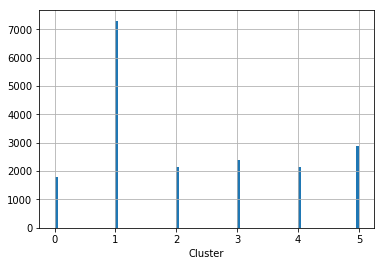

In [25]:
pd.Series(lab).hist(bins = 100)
plt.xlabel("Cluster")
plt.show()

The top 5 regimens and drugs in each cluster:

Given a cluster, what are the top drugs/regimens/outcome in that cluster, and how many days did it take until that event happened?

In [26]:
clusterinfo(df_single_cancer,
            df_pathway_events,
            single_cancer,
            top=5)

cluster  cluster_freq days in sequence      BENCHMARK_GROUP 1  \
0        0          1798        359 ± 283        75.8% DOCETAXEL   
1        1          7305        432 ± 329               14.9% EC   
2        2          2149        354 ± 286  93.2% FEC + DOCETAXEL   
3        3          2401        387 ± 251      77.9% TRASTUZUMAB   
4        4          2134        344 ± 307         96.9% HORMONES   
5        5          2874        370 ± 296              87.8% FEC   

  BENCHMARK_GROUP 2                  BENCHMARK_GROUP 3  \
0         10.4% FEC                   5.0% TRASTUZUMAB   
1  11.6% PACLITAXEL                     6.6% NOT CHEMO   
2    2.4% DOCETAXEL                           2.2% FEC   
3         10.6% FEC                     8.5% DOCETAXEL   
4          0.4% FEC  0.2% CYCLOPHOSPHAMIDE + DOCETAXEL   
5  5.4% TRASTUZUMAB                     4.9% DOCETAXEL   

                   BENCHMARK_GROUP 4             BENCHMARK_GROUP 5  \
0               2.8% FEC + DOCETAXEL                2.3% NOT CHEMO   
1  6.0% CYCLOPHOSPHAMIDE + DOCETAXEL                4.3% DENOSUMAB   
2                   0.4% TRASTUZUMAB          0.4% ZOLEDRONIC ACID   
3               0.9% FEC + DOCETAXEL  0.3% DOCETAXEL + TRASTUZUMAB   
4                     0.2% DOCETAXEL                       0.2% EC   
5               1.2% FEC + DOCETAXEL                 0.3% HORMONES   

     DRUG_GROUP_CORRECT 1    DRUG_GROUP_CORRECT 2    DRUG_GROUP_CORRECT 3  \
0  16.4% CYCLOPHOSPHAMIDE         16.2% NOT CHEMO        15.6% EPIRUBICIN   
1         16.6% NOT CHEMO  13.6% CYCLOPHOSPHAMIDE        12.5% EPIRUBICIN   
2       25.2% TRASTUZUMAB         16.4% NOT CHEMO  11.2% CYCLOPHOSPHAMIDE   
3         18.1% NOT CHEMO  15.9% CYCLOPHOSPHAMIDE        13.6% EPIRUBICIN   
4       23.8% TRASTUZUMAB         17.6% NOT CHEMO  10.7% CYCLOPHOSPHAMIDE   
5       17.7% TRASTUZUMAB         17.0% NOT CHEMO   9.7% CYCLOPHOSPHAMIDE   

  DRUG_GROUP_CORRECT 4 DRUG_GROUP_CORRECT 5 REGIMEN_OUTCOME_SUMMARY 1  \
0   11.6% FLUOROURACIL    10.5% TRASTUZUMAB                   89.6% 0   
1     9.5% TRASTUZUMAB    9.1% FLUOROURACIL                   72.3% 0   
2     11.1% EPIRUBICIN    9.3% FLUOROURACIL                   88.3% 0   
3   11.7% FLUOROURACIL      11.2% DOCETAXEL                   87.7% 0   
4     10.4% EPIRUBICIN         8.1% STEROID                   37.5% 0   
5      9.5% EPIRUBICIN    8.4% FLUOROURACIL                   91.0% 0   

  REGIMEN_OUTCOME_SUMMARY 2 REGIMEN_OUTCOME_SUMMARY 3  \
0                    6.9% 3                    1.5% 4   
1                   12.2% 3                    8.6% 2   
2                   10.5% 3                    1.0% 5   
3                    5.1% 3                    2.7% 2   
4                   37.5% 2                   25.0% 1   
5                    5.3% 3                    1.6% 2   

  REGIMEN_OUTCOME_SUMMARY 4 REGIMEN_OUTCOME_SUMMARY 5  
0                    1.3% 2                    0.8% 5  
1                    3.0% 5                    2.2% 1  
2                    0.2% 2                       NaN  
3                    2.7% 4                    1.8% 5  
4                       NaN                       NaN  
5                    1.3% 5                    0.8% 4

The TFIDF features do not include information on the order of the events that happened and the timing of the events (no. of days). The only information is the frequency of each event in a sequence and the frequency of events in all sequences.

With an LSTM it can learn the ordering of events, the days of the events and possibly other information which it might discover.

### Using LSTM as an autoencoder for clustering

The LSTM sequence model used is shown in the diagram below. Using this we can extract the encoding(a vector of length 100 say) of any sequence. These encodings will have information on the order of the sequence and it's contents(events).

The LSTM autoencoder is trained to output the same sequence that it was input. This is so that given the information from the encoding, it should be able to reconstruct the same sequence from that encoding.

<img src="docs/LSTM.png" alt="LSTM" width="800"/>

For the inputs we will use the word2vec representation of events to improve computation speed:

In [27]:
single_cancer = 'C50' #3char
df_single_cancer = df_sequences[df_sequences['PRIMARY_DIAGNOSIS'] == single_cancer]
single_cancer_sequences = df_single_cancer['sequence']
df_single_cancer.head()

nfeatures = 50
model50D = gensim.models.Word2Vec(sentences = list(df_single_cancer['sequence']), 
                                  size=nfeatures, 
                                  window=120, 
                                  workers =4, 
                                  min_count=1,
                                  iter = 5)

sequence_vectors = single_cancer_sequences.apply(lambda x: np.array([list(model50D[event]) for event in x]))

sequence_vectors = list(sequence_vectors)

#in the word2vec representation of an event
#attach the number of days on the the end of that vector

#rescale days to have roughly the same magnitude as
#the elements in word2vec vectors
sequence_days = [np.array(days) for days in df_single_cancer['sequence_days']]
max_days = np.hstack(sequence_days).max()
max_vector_value = np.hstack([np.hstack(s_v) for s_v in sequence_vectors]).max()
sequence_days = [days*(max_vector_value/max_days) for days in sequence_days]

sequence_vectors = [np.concatenate((vectors,days.reshape(days.shape[0],-1)),axis=1) 
                    for vectors,days in zip(sequence_vectors,sequence_days)]
sequence_vectors[0].shape

(11, 51)

`sequence_vectors` is a list of arrays, each array has shape (number of events, features of events = 51)

Each element in `sequence_vectors` is a sequence that is an input to the LSTM model, and we are training the model to output the same input.

The model is kept simple and is only 3 layers. We do not want to make it as robust as possible because if it is very accurate then it could be overfitted to the simulacrum which is a simulated dataset, in order for this model to generalize to the real data, the model has to be kept simple.

Some variables to set for the model:

In [28]:
nsequences = len(sequence_vectors)

#this is needed in order for the model to
#work with sequences of differing lengths
def train_generator():
    """yields sequences from sequence_vectors at random
    which is then used to train the model"""
    while True:
        s = sequence_vectors[random.randrange(nsequences)]
        s = s.reshape((1, s.shape[0], s.shape[1]))
        yield s,s
        
train_gen = train_generator()
            
input_dim = nfeatures+1
encoding_dim = 150

Initialize the structure of the LSTM sequence model:

In [29]:
inputs = Input(shape=(None, input_dim))

middle_outputs, encoding, cell_state = LSTM(encoding_dim, return_sequences=True, return_state=True)(inputs)

outputs = LSTM(input_dim, return_sequences=True)(middle_outputs)

autoencoder = Model(inputs=inputs, outputs=outputs)

Instructions for updating:
Colocations handled automatically by placer.


Train the model (~1 minutes):

In [30]:

a = time.time()

autoencoder = Model(inputs=inputs, outputs=outputs)

autoencoder.compile(optimizer='adam', loss='mse')

batch_size = 500
autoencoder.fit_generator(train_gen, 
                          steps_per_epoch=round(nsequences/batch_size), 
                          epochs=40,
                          verbose=1)

print("fit time (s): ", time.time() - a)

#make a model with the output as the encoding
encoder_model = Model(inputs = autoencoder.inputs, outputs = autoencoder.layers[1].output)

Instructions for updating:
Use tf.cast instead.
Epoch 1/40
37/37 [==============================] - 2s 41ms/step - loss: 0.1067
Epoch 2/40
37/37 [==============================] - 1s 16ms/step - loss: 0.0900
Epoch 3/40
37/37 [==============================] - 1s 21ms/step - loss: 0.0698
Epoch 4/40
37/37 [==============================] - 1s 18ms/step - loss: 0.0546
Epoch 5/40
37/37 [==============================] - 1s 20ms/step - loss: 0.0365
Epoch 6/40
37/37 [==============================] - 1s 18ms/step - loss: 0.0330
Epoch 7/40
37/37 [==============================] - 1s 18ms/step - loss: 0.0250
Epoch 8/40
37/37 [==============================] - 1s 15ms/step - loss: 0.0268
Epoch 9/40
37/37 [==============================] - 1s 20ms/step - loss: 0.0217
Epoch 10/40
37/37 [==============================] - 1s 15ms/step - loss: 0.0173
Epoch 11/40
37/37 [==============================] - 1s 22ms/step - loss: 0.0207
Epoch 12/40
37/37 [==============================] - 1s 21ms/step - lo

Get the encodings of each sequence:

In [31]:
%%time
#reshape into correct input shape
input_sequences = [np.expand_dims(s, axis=0) for s in list(sequence_vectors)]

sequence_features = np.zeros((nsequences,encoding_dim))
for i,s in enumerate(input_sequences):
    
    #get the encoding(hidden layer)
    sequence_features[i,:] = encoder_model.predict(s)[1]

CPU times: user 1min 11s, sys: 26.5 s, total: 1min 37s
Wall time: 29.9 s


Cluster the encodings

In [32]:
#clustering the encodings of all sequences
#20 clusters chosen as they are a lot more distinct,see plot below
n_clusters=20
kmeans = KMeans(n_clusters, init='k-means++', max_iter=100, n_init=1).fit(X=sequence_features)
lab = kmeans.labels_
print("lab.shape: ",lab.shape)

df_single_cancer['cluster'] = lab
df_single_cancer.to_pickle("patiend_id_cluster.pkl")

lab.shape:  (18661,)


In [33]:
#map the encodings into 2D space for visualizing
pca = PCA(n_components=2)
pca_vectors = pca.fit_transform(sequence_features)

df_single_cancer['x'] = pca_vectors[:,0]
df_single_cancer['y'] = pca_vectors[:,1]
df_single_cancer.head()

PATIENTID  \
41   10073021   
59   10120084   
64   10137351   
75   10153352   
77   10163033   

                                                                sequence  \
41                            [83, 84, 22, 85, 22, 8, 2, 47, 86, 10, 29]   
59                                                       [62, 9, 10, 83]   
64                                                   [83, 21, 10, 2, 10]   
75                                      [83, 124, 9, 10, 10, 47, 10, 30]   
77  [83, 120, 7, 124, 7, 10, 63, 17, 25, 2, 40, 125, 66, 10, 10, 12, 67]   

                                                                          sequence_days  \
41                                  [0, 97, 97, 156, 156, 156, 163, 163, 414, 414, 581]   
59                                                                       [0, 0, 0, 574]   
64                                                              [0, 559, 559, 566, 566]   
75                                               [0, 660, 681, 681, 702, 716, 716, 723]   
77  [0, 415, 415, 417, 417, 438, 439, 439, 459, 543, 544, 544, 545, 545, 552, 552, 565]   

   PRIMARY_DIAGNOSIS  sequence_length  cluster         x         y  
41               C50               11       18 -2.026175 -0.393156  
59               C50                4        4 -1.343776 -0.985480  
64               C50                5        5 -0.042004  0.775616  
75               C50                8       15  2.353064 -0.410794  
77               C50               17       17 -2.071301  0.288271

Plot the sequences in the LSTM feature space

In [34]:
sequenceclusterplot(df_single_cancer, feature_space="LSTM")

The LSTM sequence model has done well!

\- because the clusters are well separated, meaning their is some information that makes the sequences distinct. The problem now is to find out what is the information that makes each cluster distinct. 

## What do the clusters mean?

Here is some information including the top 3 regimens/drugs/outcomes of each cluster:

In [35]:
df_clusterinfo = clusterinfo(df_single_cancer,
                             df_pathway_events,
                             single_cancer,
                             top=3)
df_clusterinfo

cluster  cluster_freq days in sequence      BENCHMARK_GROUP 1  \
0         0           996        277 ± 197      15.4% TRASTUZUMAB   
1         1          1124        299 ± 137              21.2% FEC   
2         2           545        140 ± 121              44.4% FEC   
3         3           734        292 ± 208              14.5% FEC   
4         4           760        380 ± 253              23.5% FEC   
5         5           688        802 ± 227              13.5% FEC   
6         6           732        317 ± 188  27.0% FEC + DOCETAXEL   
7         7           545        528 ± 284              46.8% FEC   
8         8           931        909 ± 211        13.0% DOCETAXEL   
9         9          1002        425 ± 253              18.3% FEC   
10       10          2223        230 ± 129      19.5% TRASTUZUMAB   
11       11           633        905 ± 233              20.8% FEC   
12       12           959        308 ± 226              15.7% FEC   
13       13           768        798 ± 208         21.6% HORMONES   
14       14           835        151 ± 129         47.3% HORMONES   
15       15           512        368 ± 247              33.7% FEC   
16       16          1984        217 ± 118              18.8% FEC   
17       17           456        918 ± 224      22.3% TRASTUZUMAB   
18       18          1008        317 ± 171      27.8% TRASTUZUMAB   
19       19          1226        224 ± 125         21.1% HORMONES   

        BENCHMARK_GROUP 2                               BENCHMARK_GROUP 3  \
0               14.2% FEC                                 11.6% DOCETAXEL   
1       14.4% TRASTUZUMAB                           10.7% FEC + DOCETAXEL   
2                24.0% EC              11.1% CYCLOPHOSPHAMIDE + DOCETAXEL   
3       14.3% TRASTUZUMAB                           12.1% FEC + DOCETAXEL   
4   15.1% FEC + DOCETAXEL                                  15.1% HORMONES   
5          11.9% HORMONES                           10.0% FEC + DOCETAXEL   
6         15.7% DOCETAXEL                               15.0% TRASTUZUMAB   
7       14.3% TRASTUZUMAB                                  7.0% DOCETAXEL   
8               11.7% FEC                                7.8% TRASTUZUMAB   
9       15.1% TRASTUZUMAB                           10.1% FEC + DOCETAXEL   
10        15.4% DOCETAXEL                                       12.0% FEC   
11      10.1% TRASTUZUMAB                                        10.0% EC   
12      13.3% TRASTUZUMAB                                 12.6% DOCETAXEL   
13  20.4% FEC + DOCETAXEL                                       13.6% FEC   
14  44.3% FEC + DOCETAXEL  4.4% CYCLOPHOSPHAMIDE + DOCETAXEL + EPIRUBICIN   
15  15.4% FEC + DOCETAXEL                                  12.0% HORMONES   
16      14.9% TRASTUZUMAB                                  13.2% HORMONES   
17              12.5% FEC                           12.5% FEC + DOCETAXEL   
18              15.9% FEC                                 11.9% DOCETAXEL   
19              16.5% FEC                           15.2% FEC + DOCETAXEL   

      DRUG_GROUP_CORRECT 1    DRUG_GROUP_CORRECT 2    DRUG_GROUP_CORRECT 3  \
0   23.8% CYCLOPHOSPHAMIDE         15.0% NOT CHEMO        13.9% EPIRUBICIN   
1          17.0% NOT CHEMO  10.9% CYCLOPHOSPHAMIDE       10.9% TRASTUZUMAB   
2        59.6% TRASTUZUMAB          9.2% NOT CHEMO   5.2% CYCLOPHOSPHAMIDE   
3       21.0% FLUOROURACIL  15.1% CYCLOPHOSPHAMIDE         14.6% NOT CHEMO   
4          16.5% NOT CHEMO       16.0% TRASTUZUMAB  12.1% CYCLOPHOSPHAMIDE   
5          21.3% NOT CHEMO  14.0% CYCLOPHOSPHAMIDE        12.5% EPIRUBICIN   
6          16.6% NOT CHEMO       15.7% TRASTUZUMAB  14.1% CYCLOPHOSPHAMIDE   
7          14.8% NOT CHEMO       10.2% TRASTUZUMAB   8.4% CYCLOPHOSPHAMIDE   
8          15.6% NOT CHEMO  15.4% CYCLOPHOSPHAMIDE        14.2% EPIRUBICIN   
9          16.6% NOT CHEMO  11.7% CYCLOPHOSPHAMIDE       10.4% TRASTUZUMAB   
10         15.1% NOT CHEMO  14.6% CYCLOPHOSPHAMIDE         14.3% DOCETAXEL   


This table shows you the percentage(or chance) of events in a given cluster. For example in column `BENCHMARK_GROUP 1` cluster 0, 19.9\% FEC means 19.9\% of regimens in cluster 0 are FEC. The days are a mean and a standard deviation.

Some things to note from this are:

Cluster 18: most outcomes are '3' meaning 'Acute Chemotherapy toxicity'

Most clusters have mean days of about 200-300 or 700-900.

**due to the random initializing of the model these clusters will be numbered differently if you reran the notebook but you can still find these types of clusters.**

How well has the clustering done in terms of the order of events?

Cluster 7: has the diagnosis (event label 83) at the end of the sequences

In [39]:
df_single_cancer[df_single_cancer['cluster']==4][['sequence','cluster']].head(15)

sequence  \
59                                                                    [62, 9, 10, 83]   
78                                                   [21, 10, 14, 10, 12, 47, 46, 83]   
100                                                                      [141, 3, 83]   
174                                                           [87, 26, 2, 10, 44, 83]   
266                                                                     [142, 49, 83]   
415                      [142, 49, 9, 26, 10, 2, 9, 2, 10, 9, 10, 56, 34, 18, 56, 83]   
449                                                                  [142, 49, 8, 83]   
529           [142, 26, 34, 10, 9, 2, 10, 61, 142, 49, 10, 49, 10, 44, 18, 2, 30, 83]   
624                                                     [142, 49, 9, 10, 142, 49, 83]   
631                                           [83, 87, 34, 2, 10, 44, 58, 10, 10, 83]   
664                                       [87, 26, 38, 44, 49, 10, 44, 2, 10, 10, 83]   
791      [142, 49, 2, 26, 10, 34, 61, 49, 49, 87, 34, 26, 26, 44, 10, 44, 10, 49, 83]   
992                                                                     [142, 49, 83]   
1010                                                                    [142, 49, 83]   
1011  [142, 9, 10, 9, 49, 87, 49, 34, 49, 61, 10, 10, 30, 44, 56, 156, 87, 34, 9, 83]   

      cluster  
59          4  
78          4  
100         4  
174         4  
266         4  
415         4  
449         4  
529         4  
624         4  
631         4  
664         4  
791         4  
992         4  
1010        4  
1011        4

Cluster 0 seems to all end with 34 which is the drug CYCLOPHOSPHAMIDE

In [40]:
print(df_unique_events[df_unique_events['event_label']=='34']['event'])

df_single_cancer[df_single_cancer['cluster']==0][['sequence','cluster']].head(15)

34    DRUG_GROUP_CORRECT CYCLOPHOSPHAMIDE
Name: event, dtype: object


sequence  \
175                                                                 [83, 87, 87, 34, 9, 26, 2, 34]   
176                                                                   [83, 83, 142, 49, 26, 9, 34]   
180                                                                                [83, 87, 9, 34]   
181                                                                    [83, 87, 49, 87, 26, 9, 34]   
194                           [83, 87, 34, 9, 26, 44, 34, 2, 24, 82, 87, 87, 34, 9, 26, 9, 36, 34]   
200  [87, 26, 9, 2, 34, 36, 44, 44, 26, 10, 94, 56, 18, 56, 94, 83, 87, 9, 34, 26, 34, 49, 44, 34]   
215                                                                       [87, 34, 49, 83, 87, 34]   
221                                                                                [83, 87, 2, 34]   
222                                                                            [83, 87, 26, 9, 34]   
240                                               [83, 142, 49, 26, 9, 142, 49, 26, 26, 10, 2, 34]   
252                                                                [83, 142, 49, 9, 2, 44, 26, 34]   
258                                                                               [83, 87, 26, 34]   
277                                               [87, 10, 83, 87, 26, 34, 10, 34, 44, 44, 10, 34]   
297                                              [83, 142, 49, 87, 9, 2, 87, 34, 44, 2, 9, 10, 34]   
299                                               [87, 2, 9, 34, 58, 44, 83, 34, 2, 2, 18, 87, 34]   

     cluster  
175        0  
176        0  
180        0  
181        0  
194        0  
200        0  
215        0  
221        0  
222        0  
240        0  
252        0  
258        0  
277        0  
297        0  
299        0

Cluster 2 seems mostly having a sequence of `[83, 142, 49]` which is means

`[diagnosis breast cancer, regimen FEC, drug TRASTUZUMAB]` 

In [42]:
print(df_unique_events[df_unique_events['event_label']=='49']['event'])
print(df_unique_events[df_unique_events['event_label']=='142']['event'])

df_single_cancer[df_single_cancer['cluster']==2][['sequence','cluster']].head(15)

49    DRUG_GROUP_CORRECT TRASTUZUMAB
Name: event, dtype: object
142    BENCHMARK_GROUP FEC
Name: event, dtype: object


sequence  \
210                                                                [83, 142, 49]   
225                                                                [83, 142, 49]   
226                                                                [83, 142, 49]   
294  [83, 142, 49, 9, 10, 44, 2, 36, 49, 142, 49, 56, 8, 29, 7, 26, 26, 142, 49]   
324                                                                [83, 142, 49]   
445                                                                [83, 142, 49]   
544                                                                [83, 142, 49]   
606                                                                [83, 142, 49]   
613                                                                [83, 142, 49]   
720                                                                [83, 142, 49]   
808                                                                [83, 142, 49]   
811                                                                [83, 142, 49]   
827                                                                [83, 142, 49]   
836                                                                [83, 142, 49]   
838                                                                [83, 142, 49]   

     cluster  
210        2  
225        2  
226        2  
294        2  
324        2  
445        2  
544        2  
606        2  
613        2  
720        2  
808        2  
811        2  
827        2  
836        2  
838        2